In [75]:
import openpyxl
import re
import json
import pyperclip
import os
import shutil

from tree_node import TreeNode

import matplotlib.pyplot as plt
import networkx as nx

In [76]:
file_path = 'LCR Report.xlsx'
sheet_name = 'GAP'
cell_address = 'E500'

In [77]:
def get_formula_from_cell(workbook, sheet_name, cell_address):
    # Select the sheet by name
    sheet = workbook[sheet_name]
    
    # Access the cell using the address
    cell = sheet[cell_address]
    
    # Check if the cell contains a formula and return it
    if cell.data_type == 'f':  # 'f' means the cell contains a formula
        formula = cell.value
        return formula.lstrip('='), 0
    else:
        return None, 1 # val_status value status = 1

In [78]:
def extract_cell_references(formula, sheet_name):

    pattern = (
        r'([A-Za-z0-9_\"\'\[\]\s]+)!([A-Za-z]+[0-9]+):([A-Za-z0-9_\"\'\[\]]+)!([A-Za-z]+[0-9]+)|'  # group 0-3 Sheet1!A1:Sheet1!B2 or '2'!A1:'2'!B2
        r'([A-Za-z0-9_\"\'\[\]\s]+)!([A-Za-z]+[0-9]+):([A-Za-z]+[0-9]+)|'   # group 4-6 Sheet1!A1:B2 or '2'!A1:B2 (Sheet name left, range right)
        r'([A-Za-z]+[0-9]+):([A-Za-z0-9_\"\'\[\]\s]+)!([A-Za-z]+[0-9]+)|'   # group 7-9 A1:Sheet1!B2 (Sheet name right, range left)
        r'([A-Za-z]+[0-9]+):([A-Za-z]+[0-9]+)|'                           # group 10-11 Range without sheet, e.g., A1:B2
        r'([A-Za-z0-9_\"\'\[\]\s]+)!([A-Za-z]+[0-9]+)|'               # group 12-13 Sheet + single cell, e.g., Sheet1!A1 or "2"!A1
        r'([A-Za-z]+[0-9]+)'                                              # group 14 single cell, e.g. A2
    )
    

    matches = re.findall(pattern, formula)
    
    result = []
    seen = set()  # To track already added references and maintain uniqueness

    for match in matches:

        # group 0-3
        if match[0]:
            start_col, start_row = match[1][0].upper(), int(match[1][1:])
            end_col, end_row = match[3][0].upper(), int(match[3][1:])

            # Ensure column range is correct
            start_col_idx = ord(start_col) - ord('A')  # Convert column to index
            end_col_idx = ord(end_col) - ord('A')

            # Generate the full range of cells and add them to result
            for row in range(start_row, end_row + 1):
                for col_idx in range(start_col_idx, end_col_idx + 1):
                    col = chr(col_idx + ord('A'))  # Convert index back to letter
                    cell_ref = f'{col}{row}'.upper()
                    
                    if match[0]: sheet_name = match[0]
                    if match[2]: sheet_name = match[2]
                    
                    if (sheet_name, cell_ref) not in seen:
                        result.append((sheet_name, cell_ref))
                        seen.add((sheet_name, cell_ref))

        # group 4-6
        elif match[4]:
            start_col, start_row = match[5][0].upper(), int(match[5][1:])
            end_col, end_row = match[6][0].upper(), int(match[6][1:])

            # Ensure column range is correct
            start_col_idx = ord(start_col) - ord('A')  # Convert column to index
            end_col_idx = ord(end_col) - ord('A')

            # Generate the full range of cells and add them to result
            for row in range(start_row, end_row + 1):
                for col_idx in range(start_col_idx, end_col_idx + 1):
                    col = chr(col_idx + ord('A'))  # Convert index back to letter
                    cell_ref = f'{col}{row}'.upper()

                    if match[4]: sheet_name = match[4]
                    
                    if (sheet_name, cell_ref) not in seen:
                        result.append((sheet_name, cell_ref))
                        seen.add((sheet_name, cell_ref))
                        

        # group 7-9
        elif match[7]:
            start_col, start_row = match[7][0].upper(), int(match[7][1:])
            end_col, end_row = match[9][0].upper(), int(match[9][1:])

            # Ensure column range is correct
            start_col_idx = ord(start_col) - ord('A')  # Convert column to index
            end_col_idx = ord(end_col) - ord('A')

            # Generate the full range of cells and add them to result
            for row in range(start_row, end_row + 1):
                for col_idx in range(start_col_idx, end_col_idx + 1):
                    col = chr(col_idx + ord('A'))  # Convert index back to letter
                    cell_ref = f'{col}{row}'.upper()

                    if match[8]: sheet_name = match[8]
                    
                    if (sheet_name, cell_ref) not in seen:
                        result.append((sheet_name, cell_ref))
                        seen.add((sheet_name, cell_ref))


        # group 10-11
        elif match[10]:
            start_col, start_row = match[10][0].upper(), int(match[10][1:])
            end_col, end_row = match[11][0].upper(), int(match[11][1:])


            # Ensure column range is correct
            start_col_idx = ord(start_col) - ord('A')  # Convert column to index
            end_col_idx = ord(end_col) - ord('A')

            # Generate the full range of cells and add them to result
            for row in range(start_row, end_row + 1):
                for col_idx in range(start_col_idx, end_col_idx + 1):
                    col = chr(col_idx + ord('A'))  # Convert index back to letter
                    cell_ref = f'{col}{row}'.upper()

                    sheet_name = sheet_name
                    
                    if (sheet_name, cell_ref) not in seen:
                        result.append((sheet_name, cell_ref))
                        seen.add((sheet_name, cell_ref))

        
        # group 12-13
        elif match[12]:
            cell_ref = match[13].upper()

            if match[12]: sheet_name = match[12]
            
            if (sheet_name, cell_ref) not in seen:
                result.append((sheet_name, cell_ref))
                seen.add((sheet_name, cell_ref))


        # group 14
        elif match[14]:
            cell_ref = match[14].upper()

            sheet_name = sheet_name
            
            if (sheet_name, cell_ref) not in seen:
                result.append((sheet_name, cell_ref))
                seen.add((sheet_name, cell_ref))



    return result

In [79]:
def add_children_recursively(node, workbook, level=2, unique_pairs=None):
    

    if unique_pairs is None:
        unique_pairs = set()

    # print(level)
    # if level == 6:
    #     return unique_pairs
    
    sublevel = 0
    # For each parameter, create a child node
    for param in node.parameters:
        sublevel += 1
        sheet_name, cell_address = param

        sheet_name = sheet_name.strip("'\"")

        # print(param)

        # Check if the sheet exists in the workbook
        if sheet_name not in workbook.sheetnames:
            print(f"Warning: Sheet '{sheet_name}' not found in the workbook!")
            print(level, sublevel)
            continue
        
        # Get the formula and cell references if there’s a valid cell address
        if cell_address:
            fx, val_status = get_formula_from_cell(workbook, sheet_name, cell_address)
            if val_status == 0:
                cell_references = extract_cell_references(fx, sheet_name)
            else:
                cell_references = []

        # Create the child node
        child = TreeNode(
            level=level,
            name=f"level{level}_{sublevel}",
            cell=(sheet_name, cell_address),
            formula=fx,
            parameters=cell_references
        )

        if (sheet_name, cell_address) not in unique_pairs:
            unique_pairs.add((sheet_name, cell_address))
        
        # Add the child node to the current node
        node.add_child(child)
        
        # Recursively call this function to add children to the newly created child
        unique_pairs = add_children_recursively(child, workbook, level + 1, unique_pairs)


    return unique_pairs

In [80]:
workbook = openpyxl.load_workbook(file_path, data_only=False)

fx, val_status = get_formula_from_cell(workbook, sheet_name, cell_address)
fx

cell_references =[]
if val_status == 0:
    cell_references = extract_cell_references(fx, sheet_name)
    cell_references

print(fx, cell_references)

C500+D500 [('GAP', 'C500'), ('GAP', 'D500')]


In [81]:
if cell_references:

    root = {}
    
    level = 1
    sublevel = 1
    
    root = TreeNode(
        level = level,
        name = f"level{level}_{sublevel}",
        cell = (sheet_name, cell_address),
        formula = fx,
        parameters = cell_references
    )



    print(json.dumps(root.to_dict(), indent=4))

{
    "level": 1,
    "name": "level1_1",
    "cell": [
        "GAP",
        "E500"
    ],
    "formula": "C500+D500",
    "parameters": [
        [
            "GAP",
            "C500"
        ],
        [
            "GAP",
            "D500"
        ]
    ],
    "sublevel": []
}


In [82]:
unique_pairs = add_children_recursively(root, workbook)
unique_pairs

{('GAP', 'C500'),
 ('GAP', 'C501'),
 ('GAP', 'C502'),
 ('GAP', 'C503'),
 ('GAP', 'C504'),
 ('GAP', 'C505'),
 ('GAP', 'C506'),
 ('GAP', 'C507'),
 ('GAP', 'C508'),
 ('GAP', 'C509'),
 ('GAP', 'C510'),
 ('GAP', 'D500'),
 ('GAP', 'D501'),
 ('GAP', 'D502'),
 ('GAP', 'D503'),
 ('GAP', 'D504'),
 ('GAP', 'D505'),
 ('GAP', 'D506'),
 ('GAP', 'D507'),
 ('GAP', 'D508'),
 ('GAP', 'D509'),
 ('GAP', 'D510')}

In [83]:
json_data = json.dumps(root.to_dict(), indent=4)
pyperclip.copy(json_data)
print(json_data)

{
    "level": 1,
    "name": "level1_1",
    "cell": [
        "GAP",
        "E500"
    ],
    "formula": "C500+D500",
    "parameters": [
        [
            "GAP",
            "C500"
        ],
        [
            "GAP",
            "D500"
        ]
    ],
    "sublevel": [
        {
            "level": 2,
            "name": "level2_1",
            "cell": [
                "GAP",
                "C500"
            ],
            "formula": "C501+C502+C503+C507",
            "parameters": [
                [
                    "GAP",
                    "C501"
                ],
                [
                    "GAP",
                    "C502"
                ],
                [
                    "GAP",
                    "C503"
                ],
                [
                    "GAP",
                    "C507"
                ]
            ],
            "sublevel": [
                {
                    "level": 3,
                    "name": "level3_1",


In [84]:
unique_pairs

{('GAP', 'C500'),
 ('GAP', 'C501'),
 ('GAP', 'C502'),
 ('GAP', 'C503'),
 ('GAP', 'C504'),
 ('GAP', 'C505'),
 ('GAP', 'C506'),
 ('GAP', 'C507'),
 ('GAP', 'C508'),
 ('GAP', 'C509'),
 ('GAP', 'C510'),
 ('GAP', 'D500'),
 ('GAP', 'D501'),
 ('GAP', 'D502'),
 ('GAP', 'D503'),
 ('GAP', 'D504'),
 ('GAP', 'D505'),
 ('GAP', 'D506'),
 ('GAP', 'D507'),
 ('GAP', 'D508'),
 ('GAP', 'D509'),
 ('GAP', 'D510')}

In [85]:
len(unique_pairs)

22

In [ ]:
# # old version

#     pattern = (
#         r'([A-Za-z0-9_\"\'\[\]]+)!([A-Za-z]+[0-9]+):([A-Za-z0-9_\"\'\[\]]+)!([A-Za-z]+[0-9]+)|'  # group 0-3 Sheet1!A1:Sheet1!B2 or '2'!A1:'2'!B2
#         r'([A-Za-z0-9_\"\'\[\]]+)!([A-Za-z]+[0-9]+):([A-Za-z]+[0-9]+)|'   # group 4-6 Sheet1!A1:B2 or '2'!A1:B2 (Sheet name left, range right)
#         r'([A-Za-z]+[0-9]+):([A-Za-z0-9_\"\'\[\]]+)!([A-Za-z]+[0-9]+)|'   # group 7-9 A1:Sheet1!B2 (Sheet name right, range left)
#         r'([A-Za-z]+[0-9]+):([A-Za-z]+[0-9]+)|'                           # group 10-11 Range without sheet, e.g., A1:B2
#         r'([A-Za-z0-9_\"\'\[\]]+)!([A-Za-z]+[0-9]+)|'                     # group 12-13 Sheet + single cell, e.g., Sheet1!A1 or "2"!A1
#         r'([A-Za-z]+[0-9]+)'                                              # group 14 single cell, e.g. A2
#     )

In [121]:
# # updated version


# pattern = (
#     r'([A-Za-z0-9_\"\'\[\]\s]+)!([A-Za-z]+[0-9]+):([A-Za-z0-9_\"\'\[\]]+)!([A-Za-z]+[0-9]+)|'  # group 0-3 Sheet1!A1:Sheet1!B2 or '2'!A1:'2'!B2
#     r'([A-Za-z0-9_\"\'\[\]\s]+)!([A-Za-z]+[0-9]+):([A-Za-z]+[0-9]+)|'   # group 4-6 Sheet1!A1:B2 or '2'!A1:B2 (Sheet name left, range right)
#     r'([A-Za-z]+[0-9]+):([A-Za-z0-9_\"\'\[\]\s]+)!([A-Za-z]+[0-9]+)|'   # group 7-9 A1:Sheet1!B2 (Sheet name right, range left)
#     r'([A-Za-z]+[0-9]+):([A-Za-z]+[0-9]+)|'                           # group 10-11 Range without sheet, e.g., A1:B2
#     r'([A-Za-z0-9_\"\'\[\]\s]+)!([A-Za-z]+[0-9]+)|'               # group 12-13 Sheet + single cell, e.g., Sheet1!A1 or "2"!A1
#     r'([A-Za-z]+[0-9]+)'                                              # group 14 single cell, e.g. A2
# )


# matches = re.findall(pattern, "'F_GAP outflow'!C519")
# matches

In [86]:
def create_tree_from_json(json_data):
    # Root node is created first
    root = TreeNode(
        level=json_data['level'],
        name=json_data['name'],
        cell=json_data['cell'],
        formula=json_data['formula'],
        parameters=json_data['parameters']
    )

    # Recursively process sublevels if they exist
    for sublevel in json_data.get('sublevel', []):
        root.add_child(create_tree_from_json(sublevel))  # Recursion for nested levels

    return root

In [87]:
json_data = json.loads(json_data)

In [88]:
# Create the tree
root_node = create_tree_from_json(json_data)

# Visualize the tree
root_node.print_tree()

level1_1: ['GAP', 'E500'] -> C500+D500
  level2_1: ['GAP', 'C500'] -> C501+C502+C503+C507
    level3_1: ['GAP', 'C501'] -> None
    level3_2: ['GAP', 'C502'] -> None
    level3_3: ['GAP', 'C503'] -> SUM(C504:C506)
      level4_1: ['GAP', 'C504'] -> None
      level4_2: ['GAP', 'C505'] -> None
      level4_3: ['GAP', 'C506'] -> None
    level3_4: ['GAP', 'C507'] -> SUM(C508:C510)
      level4_1: ['GAP', 'C508'] -> None
      level4_2: ['GAP', 'C509'] -> None
      level4_3: ['GAP', 'C510'] -> None
  level2_2: ['GAP', 'D500'] -> D501+D502+D503+D507
    level3_1: ['GAP', 'D501'] -> None
    level3_2: ['GAP', 'D502'] -> None
    level3_3: ['GAP', 'D503'] -> SUM(D504:D506)
      level4_1: ['GAP', 'D504'] -> None
      level4_2: ['GAP', 'D505'] -> None
      level4_3: ['GAP', 'D506'] -> None
    level3_4: ['GAP', 'D507'] -> SUM(D508:D510)
      level4_1: ['GAP', 'D508'] -> None
      level4_2: ['GAP', 'D509'] -> None
      level4_3: ['GAP', 'D510'] -> None


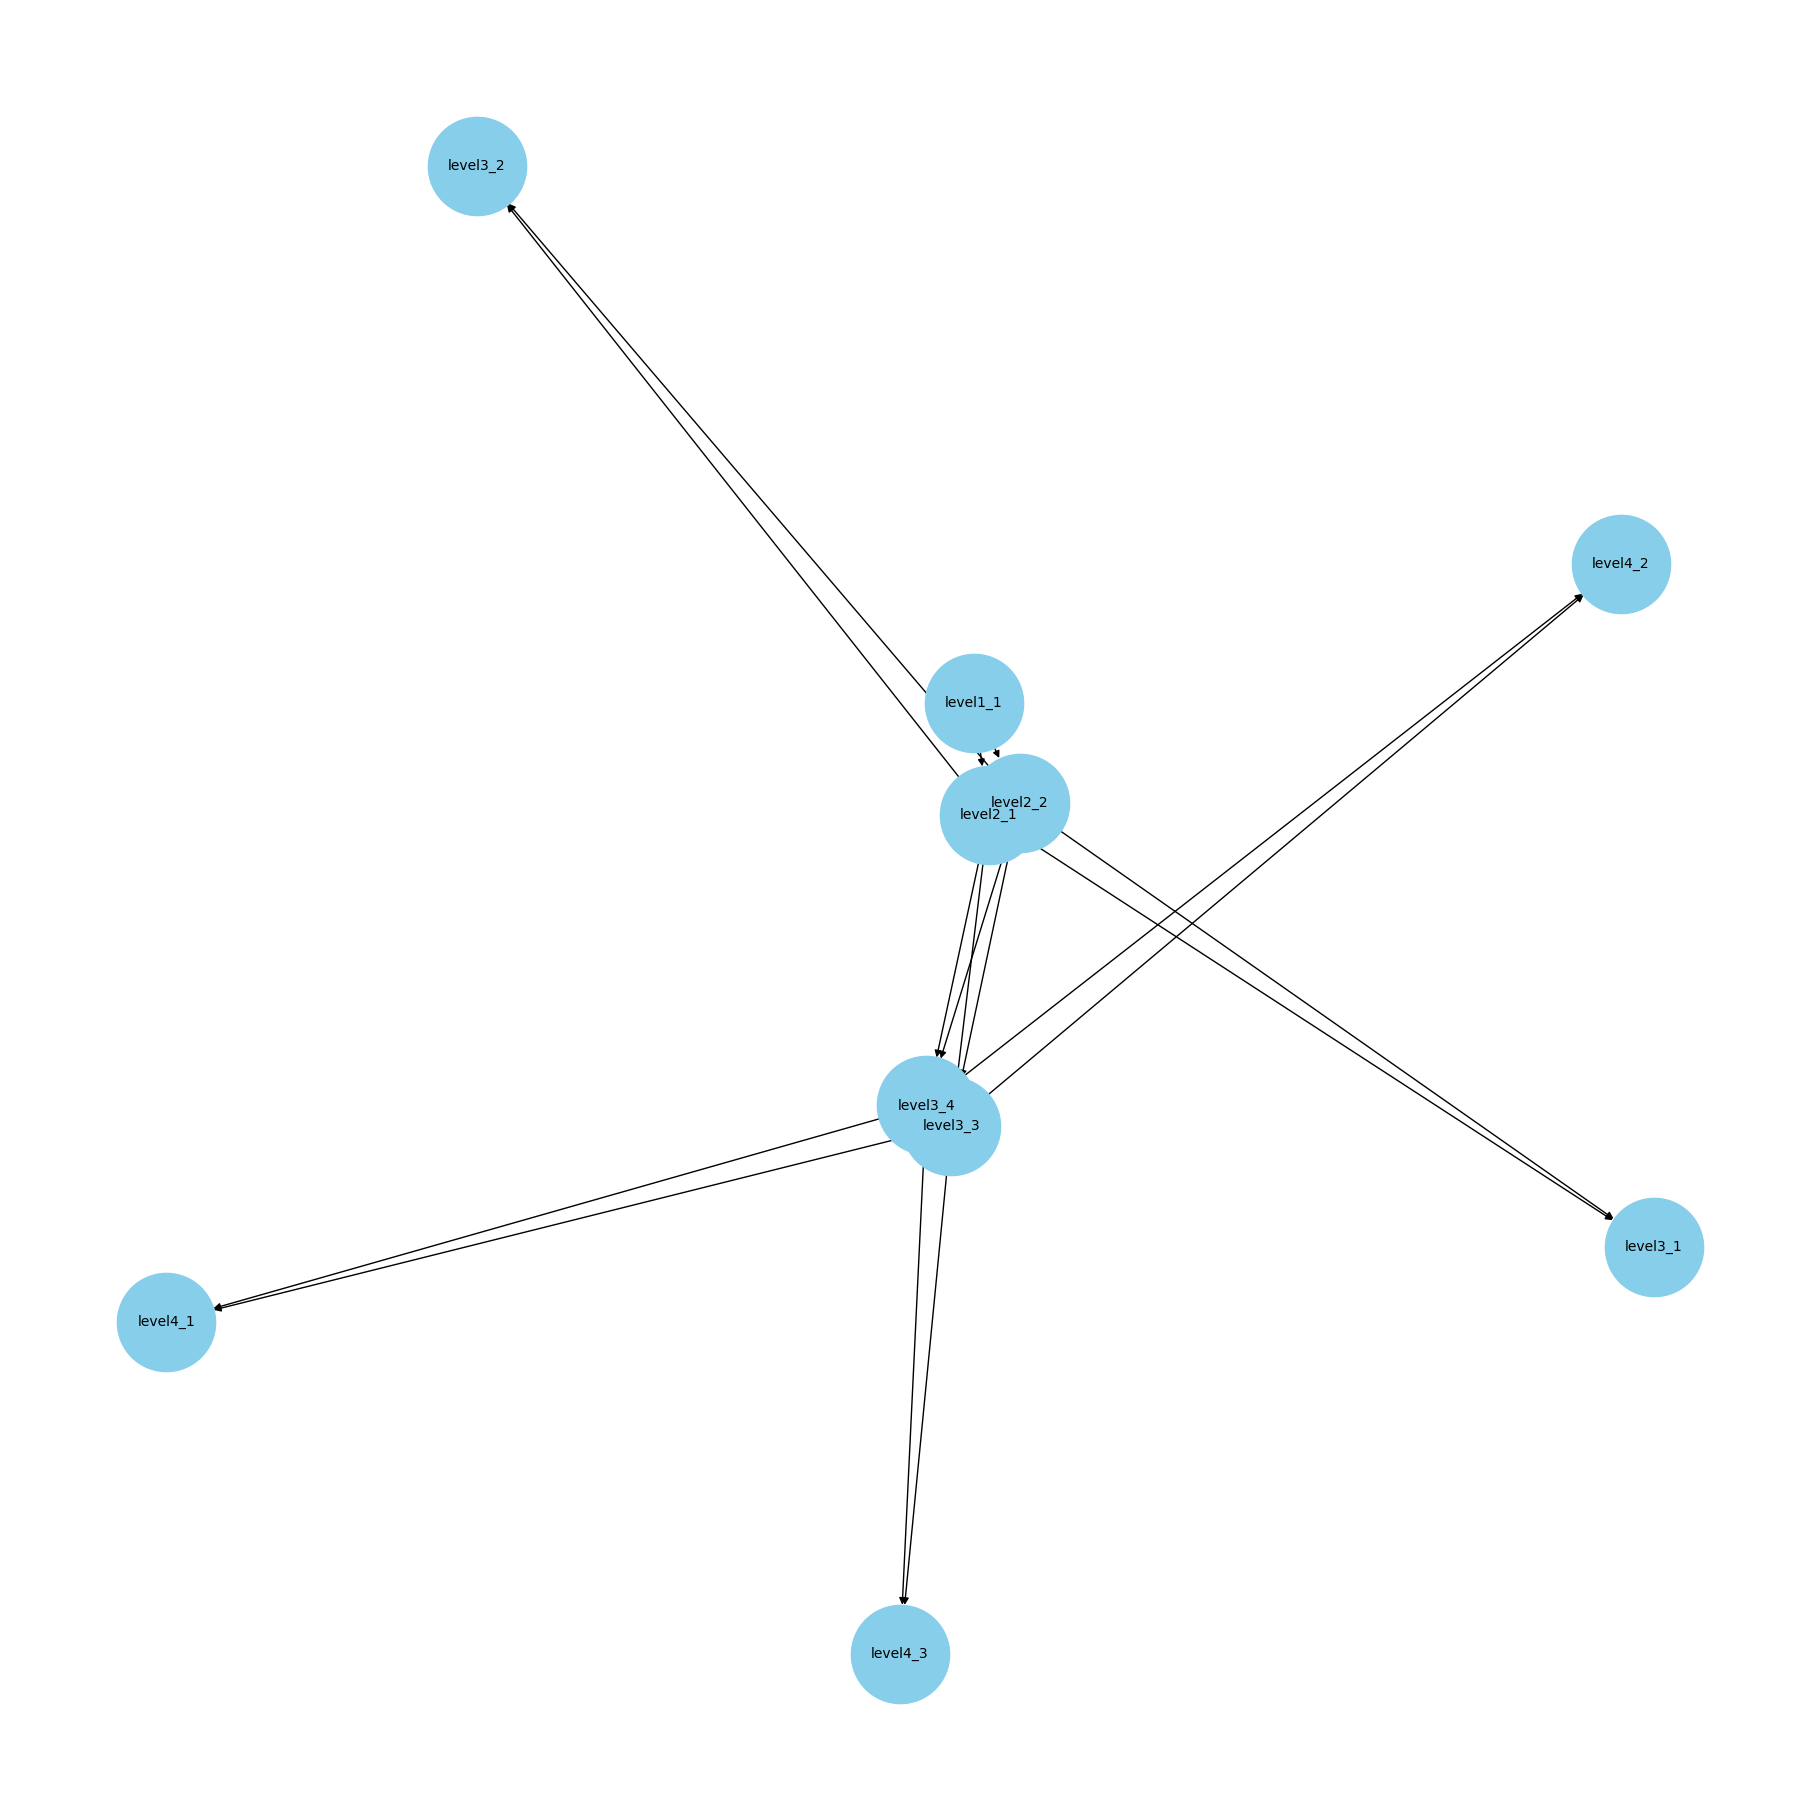

In [74]:
G = nx.DiGraph()  # Directed graph for tree structure

def add_edges_for_visualization(node):
    G.add_node(node.name)
    for child in node.sublevel:
        G.add_edge(node.name, child.name)
        add_edges_for_visualization(child)

# Add edges recursively
add_edges_for_visualization(root)

# Draw the graph
plt.figure(figsize=(18, 18))
nx.draw(G, with_labels=True, node_size=5000, node_color="skyblue", font_size=10)
plt.show()